In [205]:
#!pip install tensorflow==2.11.0
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#the model will make forecasts on the next 20 seconds (4 timesteps forward), the forecasts will be based on the previous 20 seconds (4 timesteps as input window)
#a rolling window method will be used, where the model will take 4 timesteps of data as input, and will predict the values of the next 4 timesteps
#then the input window will move by 1 timestep forward
# [(t1,h1), (t2,h2), (t3,h3), (t4,h4)] [(t5,h5), (t6,h6), (t7,h7), (t8,h8)]
# [(t2,h2), (t3,h3), (t4,h4), (t5,h5)] [(t6,h6), (t7,h7), (t8,h8), (t9,h9)]

In [187]:
def df_to_time_steps_multivariate(df, input_window, timesteps):
    cols = []
    col_names = []
    # Timesteps passati: input window
    for i in range(input_window, 0, -1):
        shifted = df.shift(i)
        cols.append(shifted)
        # Per ogni colonna del df, crea un nome con suffisso t-i
        names = [f"{col}_t-{i}" for col in df.columns]
        col_names.extend(names)
    # Timesteps correnti ed in avanti: output
    for i in range(0, timesteps):
        shifted = df.shift(-i)
        cols.append(shifted)
        if i == 0:
            names = [f"{col}_t" for col in df.columns]
        else:
            names = [f"{col}_t+{i}" for col in df.columns]
        col_names.extend(names)
    df_timesteps = pd.concat(cols, axis=1)
    df_timesteps.columns = col_names
    df_timesteps.dropna(inplace=True)
    return df_timesteps

def to_supervised(d_set, past_window, future_window, var_option="tot", step_future=None):
    """
    d_set: DataFrame o array numpy di forma (n_samples, 16), 
           dove 16 = (past_window + future_window) * n_features, nel nostro caso (4+4)*2.
    past_window: numero di timesteps di input (4)
    future_window: numero di timesteps da prevedere (4)
    var_option: "tot" per entrambe le variabili, "temp" per solo temperature, "hum" per solo umidità.
    step_future: se specificato (1 a future_window) allora vengono prese solo le y di quel timestep futuro.
    """
    # Converti in array se non lo è già
    data = d_set.values if hasattr(d_set, "values") else d_set
    total_steps = past_window + future_window  # ad es. 8
    n_features = data.shape[1] // total_steps      # ad es. 2
    # Ridimensiona in (n_samples, total_steps, n_features)
    data = data.reshape((data.shape[0], total_steps, n_features))
    
    # Definisci X e Y_full (tutte le y future)
    X = data[:, :past_window, :]  # forma: (n_samples, past_window, n_features)
    Y_full = data[:, past_window:past_window+future_window, :]  # forma: (n_samples, future_window, n_features)
    
    if var_option == "tot":
        if step_future is None:
            # restituisce entrambe le variabili per tutti i timesteps futuri
            Y = Y_full.reshape(Y_full.shape[0], future_window * n_features)
        else:
            # restituisce la coppia di valori (temp e hum) corrispondente al timestep futuro specifico
            Y = Y_full[:, step_future - 1, :]  # forma: (n_samples, n_features)
    elif var_option == "temp":
        if step_future is None:
            # restituisce i valori di temperature per tutti i timesteps futuri (colonna 0)
            Y = Y_full[:, :, 0]  # forma: (n_samples, future_window)
        else:
            Y = Y_full[:, step_future - 1, 0]  # forma: (n_samples,)
    elif var_option == "hum":
        if step_future is None:
            # restituisce i valori di umidità per tutti i timesteps futuri (colonna 1)
            Y = Y_full[:, :, 1]  # forma: (n_samples, future_window)
        else:
            Y = Y_full[:, step_future - 1, 1]  # forma: (n_samples,)
    else:
        raise ValueError("var_option deve essere 'tot', 'temp' o 'hum'")
    
    return np.array(X), np.array(Y)

def make_lstm_model(time_steps, lstm_units, final_units=1):
    # Usa n_features=2, visto che x_train ha shape (None, time_steps, 2)
    model = keras.Sequential([
        tf.keras.layers.Input(shape=(time_steps, 2), name="input"),
        tf.keras.layers.LSTM(units=lstm_units, return_sequences=False),
        tf.keras.layers.Dense(final_units),
        # Supponendo di voler una singola predizione (per esempio, la temperatura futura)
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
    return model

def make_cnn_model(window_size, time_steps, conv_filters, n_features, final_units=1):
       
    model = keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, n_features), name="input"),
        tf.keras.layers.Conv1D(conv_filters, kernel_size=3),
        tf.keras.layers.Conv1D(conv_filters, kernel_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(15, activation='linear'),
        tf.keras.layers.Dense(final_units, activation='linear')
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
    return model

def make_mlp_model(time_steps, mlp_units, final_units=1):
    # Se final_units non è specificato, impostiamo l'output su 1 (predizione singola)
    
    model = keras.Sequential([
        tf.keras.layers.Input(shape=(time_steps, 2), name="input"),
        tf.keras.layers.Flatten(),  # appiattisce l'input in (time_steps*2,)
        tf.keras.layers.Dense(mlp_units, activation='relu'),
        tf.keras.layers.Dense(mlp_units // 2, activation='relu'),
        tf.keras.layers.Dense(final_units, activation='linear')
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
    return model

def make_mlp_model_2(time_steps, mlp_units, final_units=-1):
    # Se final_units non è specificato, impostiamo l'output su 1 (predizione singola)
    
    model = keras.Sequential([
        tf.keras.layers.Input(shape=(time_steps, 2), name="input"),
        tf.keras.layers.Flatten(),  # appiattisce l'input in (time_steps*2,)
        tf.keras.layers.Dense(mlp_units, activation='relu'),
        tf.keras.layers.Dense(mlp_units, activation='relu'),
        tf.keras.layers.Dense(mlp_units // 2, activation='relu'),
        tf.keras.layers.Dense(mlp_units // 2, activation='relu'),
        tf.keras.layers.Dense(final_units, activation='linear')
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
    return model

def make_mlp_model_3(time_steps, mlp_units, final_units=1):
    # Se final_units non è specificato, impostiamo l'output su 1 (predizione singola)
    
    model = keras.Sequential([
        tf.keras.layers.Input(shape=(time_steps, 2), name="input"),
        tf.keras.layers.Flatten(),  # appiattisce l'input in (time_steps*2,)
        tf.keras.layers.Dense(mlp_units, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # aggiungi un dropout per evitare overfitting
        tf.keras.layers.Dense(mlp_units, activation='relu'), # sotto un dropout
        tf.keras.layers.Dense(mlp_units // 2, activation='relu'),
        tf.keras.layers.Dense(mlp_units // 2, activation='relu'),
        tf.keras.layers.Dense(final_units, activation='linear')
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
    return model

def train_plot_results(model, title, label_name, true_labels_test, true_labels_train, true_labels_val, x_test, x_train, x_val, epochs=50):
    
    model.summary()
    history = model.fit(
    x_train,
    true_labels_train,
    epochs=epochs,
    validation_data=(x_val, true_labels_val),
    verbose=0,
    )

    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title(title)
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # evaluate the model
    model.evaluate(x_test, true_labels_test)

    #predictions of the model using test data as input
    pred =  model.predict(x_test, verbose=0)

    pred_result = pd.DataFrame(data={label_name: pred.flatten(), 'Actuals': true_labels_test.flatten()})
    pred_result.plot()

In [165]:
df = pd.read_csv("data/influxdata_hum_30d.csv", skiprows=3)
hum_df = df[["humidity", "time"]]
print(hum_df.head())

df = pd.read_csv("data/influxdata_temp_30d.csv", skiprows=3)
temp_df = df[["temperature", "time"]]
print(temp_df.head())

   humidity                            time
0        42  2025-07-01T08:07:20.676725738Z
1        42  2025-07-01T08:07:25.676872041Z
2        42  2025-07-01T08:07:30.728046958Z
3        42  2025-07-01T08:07:35.665024568Z
4        42  2025-07-01T08:07:40.666718757Z
   temperature                            time
0         31.5  2025-07-01T08:07:20.163877245Z
1         31.5  2025-07-01T08:07:25.167502537Z
2         31.5  2025-07-01T08:07:30.171826467Z
3         31.5  2025-07-01T08:07:35.160252721Z
4         31.5   2025-07-01T08:07:40.16603943Z


In [171]:
# Usa .copy() per evitare SettingWithCopyWarning
hum_dfc = hum_df.copy()
temp_dfc = temp_df.copy()

# Converti la colonna 'time' in datetime
hum_dfc["time"] = pd.to_datetime(hum_dfc["time"])
temp_dfc["time"] = pd.to_datetime(temp_dfc["time"])

# Ordina i DataFrame per 'time' (necessario per merge_asof)
hum_dfc = hum_dfc.sort_values("time")
temp_dfc = temp_dfc.sort_values("time")

# Unisci i DataFrame utilizzando merge_asof: viene cercato il match a meno di 2 secondi
merged_df = pd.merge_asof(temp_dfc, hum_dfc, on="time", 
                          tolerance=pd.Timedelta("2s"), 
                          direction="nearest")

# Scarta le righe per cui non c'è match (NaN)
merged_df = merged_df.dropna()

merged_df = merged_df[ merged_df["temperature"] >= 0 ]
print("\nValori unici di temperature:")
mergeed_df = merged_df.set_index('time')
print(merged_df["temperature"].unique())

# Seleziona le colonne numeric che vuoi processare (ad esempio, temperature e humidity)
multivariate_df = merged_df[["temperature", "humidity"]].copy()
future_time_steps = 4
past_time_steps = 4
df_time_steps = df_to_time_steps_multivariate(multivariate_df, past_time_steps, future_time_steps)
print(df_time_steps.shape)  # Dovrebbe essere (n, 16): 2 variabili x (4+4) timesteps
#print(df_time_steps.head())



Valori unici di temperature:
[28.4 28.3 28.5 28.6 28.7 28.8 28.9 29.  29.1 29.2 29.3 29.4 29.5 29.6
 29.7 29.8 29.9 30.  30.1 30.2 30.3 30.4 30.5 30.6 30.7 30.8 30.9 31.
 31.1 31.2 31.3 31.4 31.5 31.6 31.7 31.8 31.9]
(195868, 16)


In [184]:
values = df_time_steps.values

train_samples = int(0.6* len(values))
valid_samples = int(0.2*len(values))
test_samples = len(values) - (train_samples + valid_samples)

train = values[:train_samples]
valid = values[train_samples : -test_samples]
test = values[-test_samples:]

#split and reshape input and label data
x_train, y_train_temp = to_supervised(train, past_time_steps, future_time_steps, var_option="temp", step_future=1)
x_test, y_test_temp = to_supervised(test, past_time_steps, future_time_steps, var_option="temp", step_future=1)
x_val, y_val_temp = to_supervised(valid, past_time_steps, future_time_steps, var_option="temp", step_future=1)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train_temp.shape=}")
print(f"{y_test_temp.shape=}")

x_train.shape=(117520, 4, 2)
x_test.shape=(39175, 4, 2)
y_train_temp.shape=(117520,)
y_test_temp.shape=(39175,)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 2, 10)          │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 1, 10)          │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


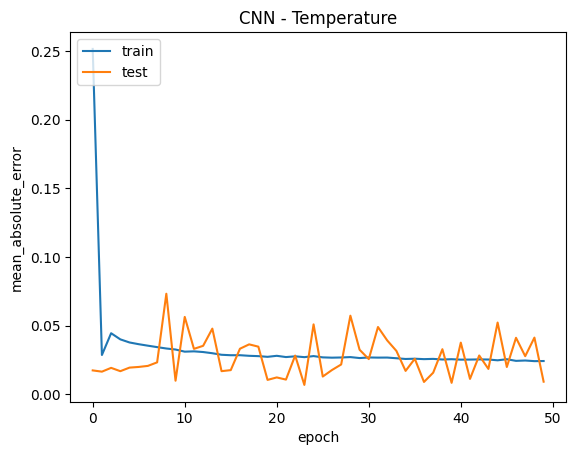

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - loss: 4.1565e-04 - mean_absolute_error: 0.0125


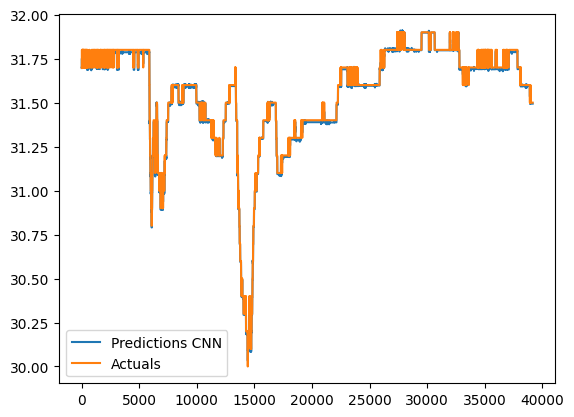

In [179]:
model = make_cnn_model(past_time_steps, future_time_steps, conv_filters=10, n_features=2, final_units=1)

train_plot_results(model, "CNN - Temperature", "Predictions CNN", y_test_temp.copy(), y_train_temp.copy(), y_val_temp.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533 (2.08 KB)

 Trainable params: 533 (2.08 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


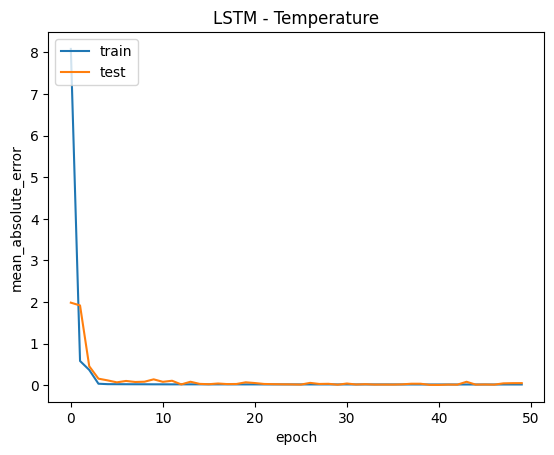

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 0.0040 - mean_absolute_error: 0.0601


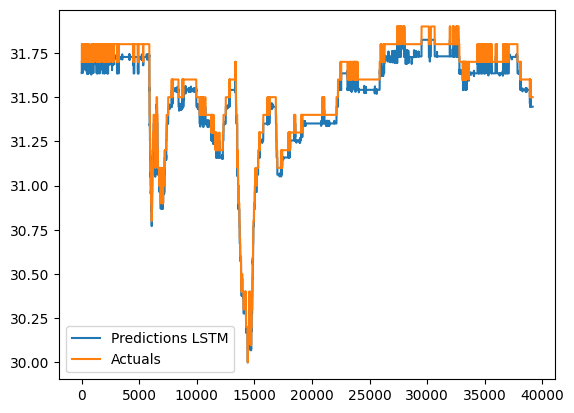

In [ ]:
model = make_lstm_model(future_time_steps, lstm_units=10, final_units=1)
train_plot_results(model, "LSTM - Temperature", "Predictions LSTM", y_test_temp.copy(), y_train_temp.copy(), y_val_temp.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_29 (Flatten)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


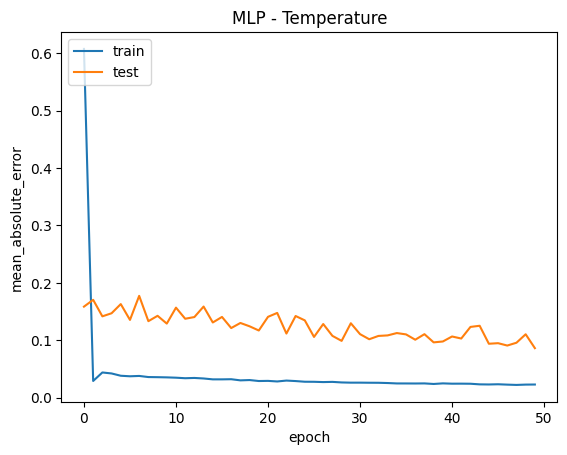

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - loss: 0.0250 - mean_absolute_error: 0.0323


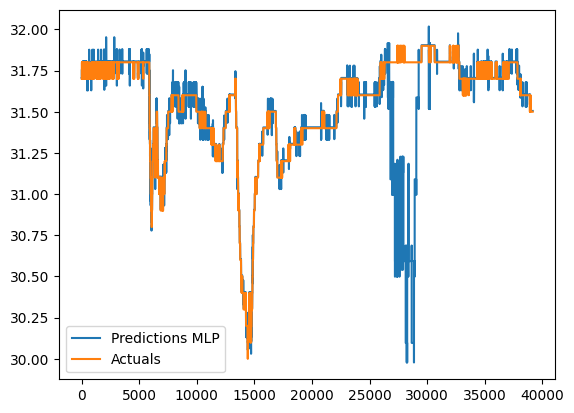

In [ ]:
model = make_mlp_model(future_time_steps, mlp_units=10, final_units=1)
train_plot_results(model, "MLP - Temperature", "Predictions MLP", y_test_temp.copy(), y_train_temp.copy(), y_val_temp.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_33 (Flatten)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291 (1.14 KB)

 Trainable params: 291 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


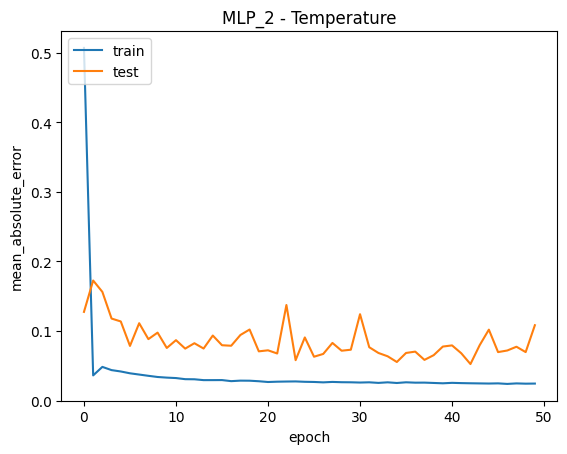

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - loss: 0.0142 - mean_absolute_error: 0.0783


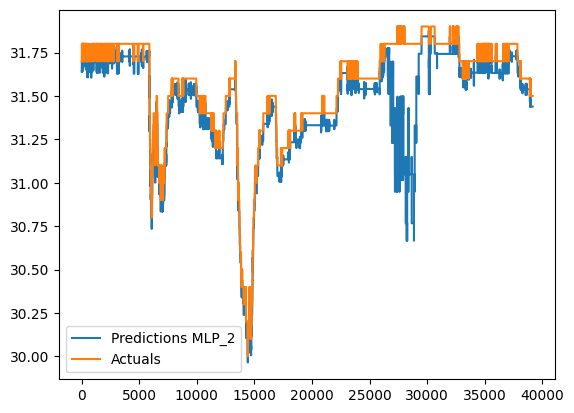

In [188]:
model = make_mlp_model_2(future_time_steps, mlp_units=10, final_units=1)
train_plot_results(model, "MLP_2 - Temperature", "Predictions MLP_2", y_test_temp.copy(), y_train_temp.copy(), y_val_temp.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

In [190]:
#split and reshape input and label data
x_train, y_train_hum = to_supervised(train, past_time_steps, future_time_steps, var_option="hum", step_future=1)
x_test, y_test_hum = to_supervised(test, past_time_steps, future_time_steps, var_option="hum", step_future=1)
x_val, y_val_hum = to_supervised(valid, past_time_steps, future_time_steps, var_option="hum", step_future=1)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train_hum.shape=}")
print(f"{y_test_hum.shape=}")

x_train.shape=(117520, 4, 2)
x_test.shape=(39175, 4, 2)
y_train_hum.shape=(117520,)
y_test_hum.shape=(39175,)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 2, 10)          │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 1, 10)          │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


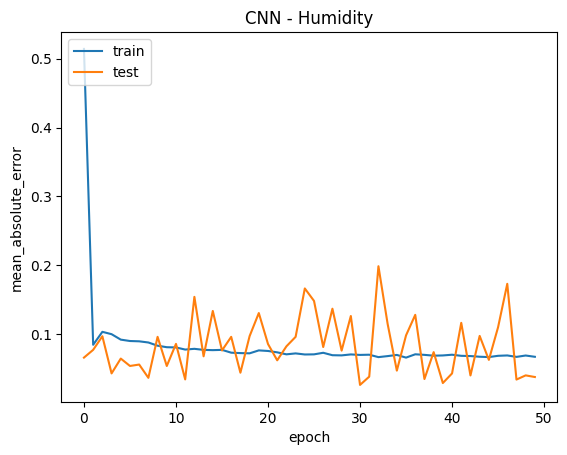

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 0.0121 - mean_absolute_error: 0.0325


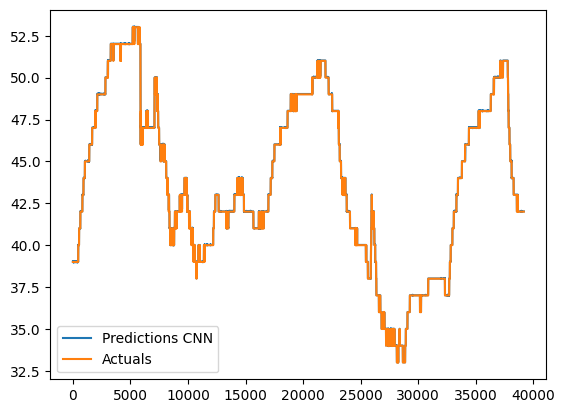

In [191]:
model = make_cnn_model(past_time_steps, future_time_steps, conv_filters=10, n_features=2, final_units=1)
train_plot_results(model, "CNN - Humidity", "Predictions CNN", y_test_hum.copy(), y_train_hum.copy(), y_val_hum.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533 (2.08 KB)

 Trainable params: 533 (2.08 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


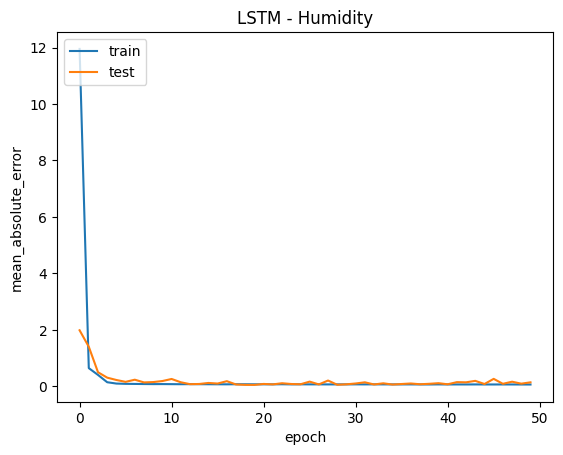

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.0434 - mean_absolute_error: 0.1701


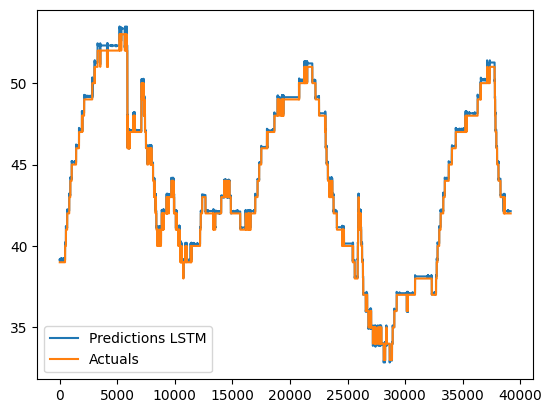

In [193]:
model = make_lstm_model(future_time_steps, lstm_units=10, final_units=1)
train_plot_results(model, "LSTM - Humidity", "Predictions LSTM", y_test_hum.copy(), y_train_hum.copy(), y_val_hum.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_35 (Flatten)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


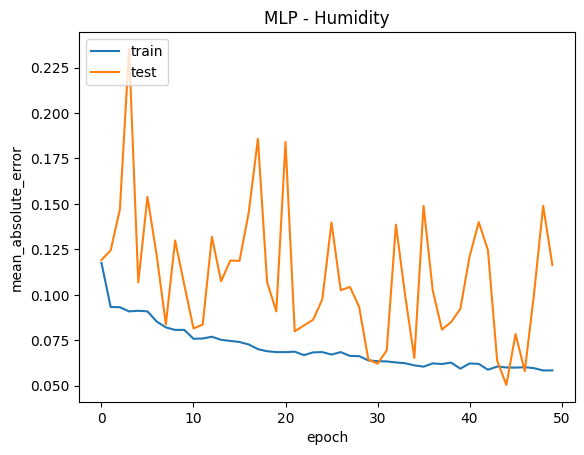

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - loss: 0.0219 - mean_absolute_error: 0.1059


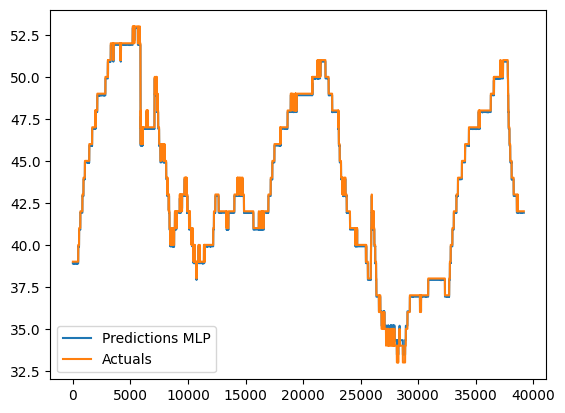

In [195]:
model = make_mlp_model(future_time_steps, mlp_units=10, final_units=1)
train_plot_results(model, "MLP - Humidity", "Predictions MLP", y_test_hum.copy(), y_train_hum.copy(), y_val_hum.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_36 (Flatten)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291 (1.14 KB)

 Trainable params: 291 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


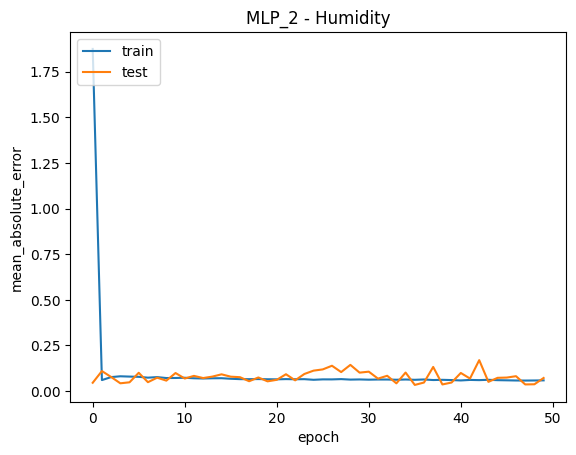

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - loss: 0.0161 - mean_absolute_error: 0.0625


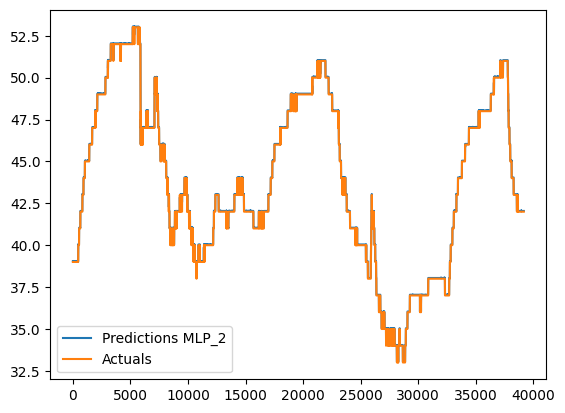

In [196]:
model = make_mlp_model_2(future_time_steps, mlp_units=10, final_units=1)
train_plot_results(model, "MLP_2 - Humidity", "Predictions MLP_2", y_test_hum.copy(), y_train_hum.copy(), y_val_hum.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_37 (Flatten)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291 (1.14 KB)

 Trainable params: 291 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


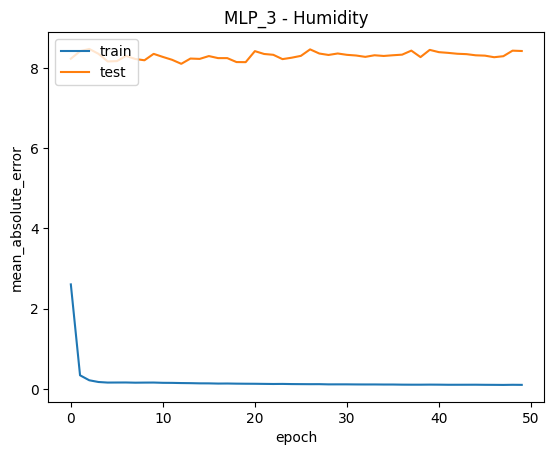

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - loss: 80.5026 - mean_absolute_error: 8.9197


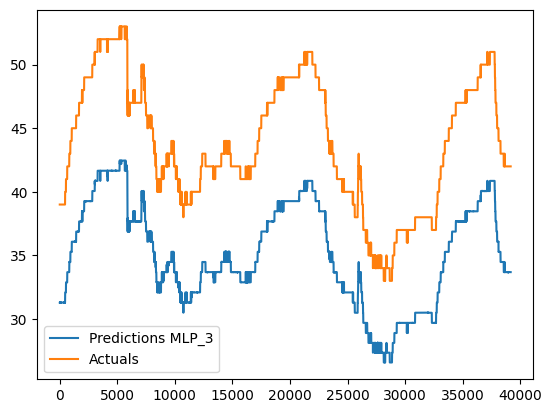

In [197]:
model = make_mlp_model_3(future_time_steps, mlp_units=10, final_units=1)
train_plot_results(model, "MLP_3 - Humidity", "Predictions MLP_3", y_test_hum.copy(), y_train_hum.copy(), y_val_hum.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

In [198]:
#split and reshape input and label data
x_train, y_train_hum = to_supervised(train, past_time_steps, future_time_steps, var_option="hum", step_future=1)
x_test, y_test_hum = to_supervised(test, past_time_steps, future_time_steps, var_option="hum", step_future=1)
x_val, y_val_hum = to_supervised(valid, past_time_steps, future_time_steps, var_option="hum", step_future=1)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train_hum.shape=}")
print(f"{y_test_hum.shape=}")

#split and reshape input and label data
x_train, y_train_temp = to_supervised(train, past_time_steps, future_time_steps, var_option="temp", step_future=1)
x_test, y_test_temp = to_supervised(test, past_time_steps, future_time_steps, var_option="temp", step_future=1)
x_val, y_val_temp = to_supervised(valid, past_time_steps, future_time_steps, var_option="temp", step_future=1)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train_temp.shape=}")
print(f"{y_test_temp.shape=}")

x_train.shape=(117520, 4, 2)
x_test.shape=(39175, 4, 2)
y_train_hum.shape=(117520,)
y_test_hum.shape=(39175,)
x_train.shape=(117520, 4, 2)
x_test.shape=(39175, 4, 2)
y_train_temp.shape=(117520,)
y_test_temp.shape=(39175,)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 2, 10)          │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 1, 10)          │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


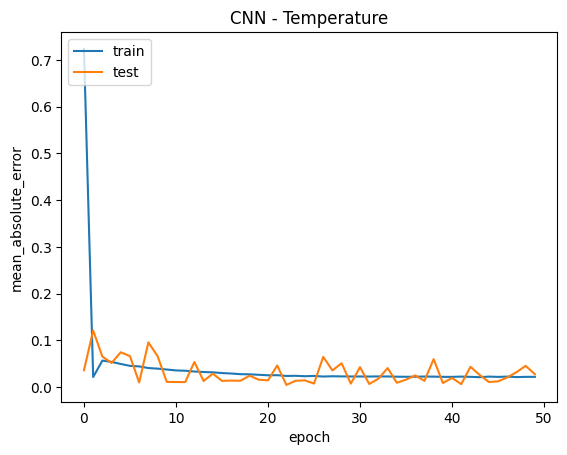

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - loss: 0.0011 - mean_absolute_error: 0.0303


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)              │ (None, 2, 10)          │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 1, 10)          │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


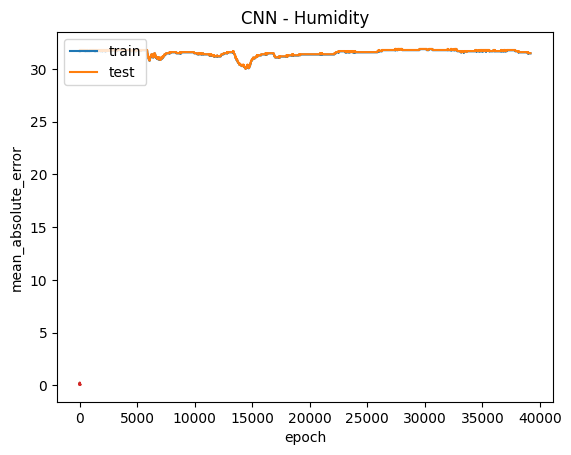

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.0119 - mean_absolute_error: 0.0271


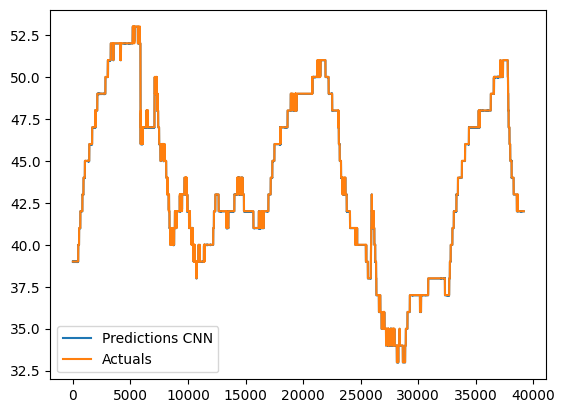

In [200]:
model_temp_cnn = make_cnn_model(past_time_steps, future_time_steps, conv_filters=10, n_features=2, final_units=1)
model_hum_cnn = make_cnn_model(past_time_steps, future_time_steps, conv_filters=10, n_features=2, final_units=1)

train_plot_results(model_temp_cnn, "CNN - Temperature", "Predictions CNN", y_test_temp.copy(), y_train_temp.copy(), y_val_temp.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)
train_plot_results(model_hum_cnn, "CNN - Humidity", "Predictions CNN", y_test_hum.copy(), y_train_hum.copy(), y_val_hum.copy(), x_test.copy(), x_train.copy(), x_val.copy(), epochs=50)

In [201]:
#convert the model in tensorflowLite

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_temp_cnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.convert()

# Save the converted model to a file
with open("model_temp_cnn.tflite", "wb") as f:
    f.write(converter.convert())

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_hum_cnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.convert()

# Save the converted model to a file
with open("model_hum_cnn.tflite", "wb") as f:
    f.write(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpj9hkf85_\assets


INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpj9hkf85_\assets


Saved artifact at 'C:\Users\Utente\AppData\Local\Temp\tmpj9hkf85_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 2), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2645228569696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228571984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228576032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228574096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228577088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228574976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228578672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228575152: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpa0_g28_q\assets


INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpa0_g28_q\assets


Saved artifact at 'C:\Users\Utente\AppData\Local\Temp\tmpa0_g28_q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 2), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2645228569696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228571984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228576032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228574096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228577088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228574976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228578672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645228575152: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpxip5c4wm\assets


INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpxip5c4wm\assets


Saved artifact at 'C:\Users\Utente\AppData\Local\Temp\tmpxip5c4wm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 2), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2645690241040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690246848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690243152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690239456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690238752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690253008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690251248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690238400: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpf6mvto7_\assets


INFO:tensorflow:Assets written to: C:\Users\Utente\AppData\Local\Temp\tmpf6mvto7_\assets


Saved artifact at 'C:\Users\Utente\AppData\Local\Temp\tmpf6mvto7_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 2), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2645690241040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690246848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690243152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690239456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690238752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690253008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690251248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2645690238400: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [202]:
!xxd -i model_temp_cnn.tflite > model_temp_cnn.cc
!xxd -i model_hum_cnn.tflite > model_hum_cnn.cc

"xxd" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"xxd" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [ ]:
# Visualizza le prime 10 righe di model_temp_cnn.cc
print("Contenuto di model_temp_cnn.cc:")
with open("model_temp_cnn.cc", "r") as f:
    for line in f.readlines()[:10]:
        print(line.strip())

print("\n-----------------\n")

# Visualizza le prime 10 righe di model_hum_cnn.cc
print("Contenuto di model_hum_cnn.cc:")
with open("model_hum_cnn.cc", "r") as f:
    for line in f.readlines()[:10]:
        print(line.strip())

In [209]:
temp_size = os.path.getsize("model_temp_cnn.cc")
hum_size = os.path.getsize("model_hum_cnn.cc")
print("\nDimensione model_temp_cnn.cc:", temp_size, "byte")
print("Dimensione model_hum_cnn.cc:", hum_size, "byte")
print("Dimensione model_temp_cnn.tflite:", os.path.getsize("model_temp_cnn.tflite"), "byte")
print("Dimensione model_hum_cnn.tflite:", os.path.getsize("model_hum_cnn.tflite"), "byte")


Dimensione model_temp_cnn.cc: 31393 byte
Dimensione model_hum_cnn.cc: 31391 byte
Dimensione model_temp_cnn.tflite: 5076 byte
Dimensione model_hum_cnn.tflite: 5076 byte
